# **Introduction**

Bitcoins are one of the largest and most well-known cryptocurrencies in the world. It first appeared in 2009 and has grown exponentially since gaining mainstream appeal. Over the years a is a wide range of opinions about the currency formed. Some consider it an investment, a fad and I simply consider it an eco-friendly alternative to burning money.

This notebook has two goals:

* Finishing an exploratory data analysis of the Bitcoin price
* Creating a SARIMAX univariate prediction of the Bitcoin price 

# **Library and data import**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno

import datetime
from pandas.tseries.offsets import DateOffset
from pandas.tseries.offsets import MonthEnd

import statsmodels.api as sm
from scipy import stats
import itertools

import gc
import warnings
warnings.filterwarnings("ignore")

plt.style.use("fivethirtyeight")

In [2]:
path = "../input/bitcoin-historical-data/bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv"
df = pd.read_csv(path)

# **Exploratory data analysis**

In [3]:
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Each row presents a 1-minute trade interval. The NaN fields represent timestamps without any trades occurring. Most of the NaN fields are present very early in the dataset. Bitcoins were mostly unknown in this period, which means no a lot of trades.

Looking at the Timestamp column, we need to convert it from seconds.

In [4]:
#Date conversion
df["Timestamp"] = pd.to_datetime(df["Timestamp"], unit="s",origin="unix")

Text(0.07, 1, 'Missing data check')

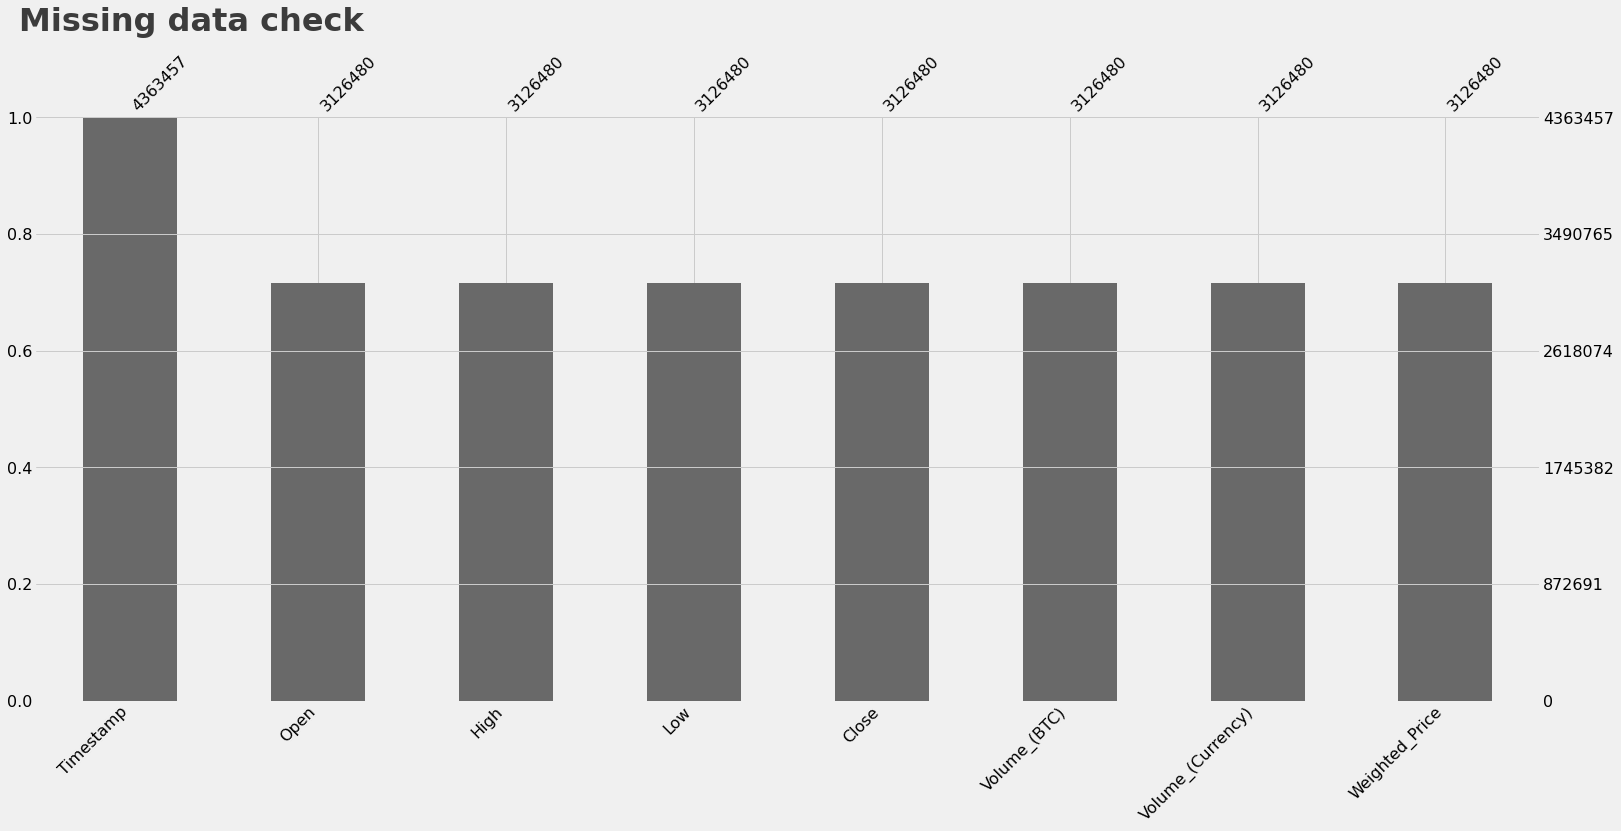

In [5]:
ax, fig = plt.subplots(figsize=(10,5))

msno.bar(df)

ax.text(0.07,1, s="Missing data check", fontsize=32, weight="bold", alpha=0.75)

In [6]:
df.set_index(df["Timestamp"],drop=True,inplace=True)
#Hour
df_hour = df.resample("h").mean()

I am going to resample the data to an hourly format and analyse it further as such.

Text(2011-06-30, 21000, 'There is no major difference between the mean opening and closing prices.')

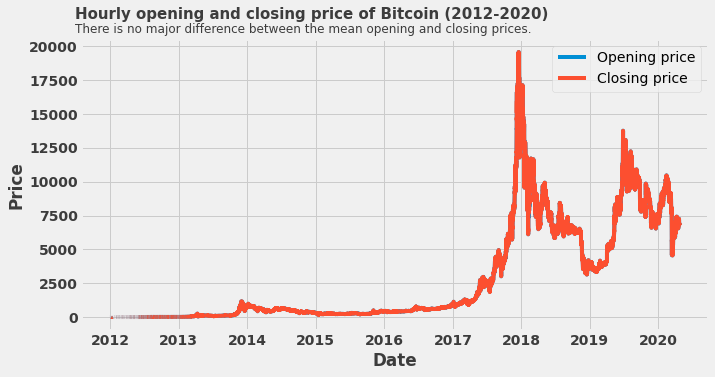

In [7]:
ax, fig = plt.subplots(figsize = (10,5))

plt.plot(df_hour["Open"], label="Opening price")
plt.plot(df_hour["Close"], label="Closing price")

plt.xticks(alpha=0.75, weight="bold")
plt.yticks(alpha=0.75, weight="bold")

plt.xlabel("Date",alpha=0.75, weight="bold")
plt.ylabel("Price",alpha=0.75, weight="bold")

plt.legend()

plt.text(x=datetime.date(2011, 6, 30), y=22000, s="Hourly opening and closing price of Bitcoin (2012-2020)",
fontsize=15, weight="bold", alpha=0.75)
plt.text(x=datetime.date(2011, 6, 30), y=21000, s="There is no major difference between the mean opening and closing prices.",fontsize=12, alpha=0.75)

To further highlight the differences between the opening and closing reads, I am going to create a column that represents the differences between these prices on the hourly dataset. The modification will allow the data to be clearly visually presented.

Text(2011-06-30, 22, 'Larger price fluctuations started happening in 2018 when Bitcoin started gaining mainstream appeal.')

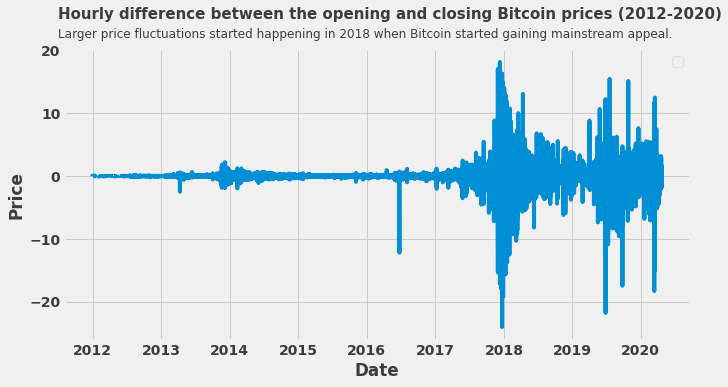

In [8]:
#Data

df_hour["hourly_diff"] = df_hour["Close"] - df_hour["Open"]

#Plot
ax, fig = plt.subplots(figsize = (10,5))

plt.plot(df_hour["hourly_diff"])

plt.xticks(alpha=0.75, weight="bold")
plt.yticks(alpha=0.75, weight="bold")

plt.xlabel("Date",alpha=0.75, weight="bold")
plt.ylabel("Price",alpha=0.75, weight="bold")

plt.legend()

plt.text(x=datetime.date(2011, 6, 30), y=25, s="Hourly difference between the opening and closing Bitcoin prices (2012-2020)",
fontsize=15, weight="bold", alpha=0.75)
plt.text(x=datetime.date(2011, 6, 30), y=22, s="Larger price fluctuations started happening in 2018 when Bitcoin started gaining mainstream appeal.",fontsize=12, alpha=0.75)

Text(2011-06-30, 21000, 'This is the main metric that we would like to predict.')

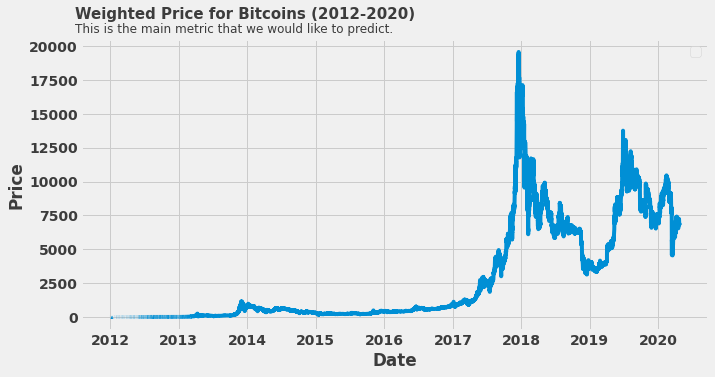

In [9]:
ax, fig = plt.subplots(figsize = (10,5))

plt.plot(df_hour["Weighted_Price"])

plt.xticks(alpha=0.75, weight="bold")
plt.yticks(alpha=0.75, weight="bold")

plt.xlabel("Date",alpha=0.75, weight="bold")
plt.ylabel("Price",alpha=0.75, weight="bold")

plt.legend()

plt.text(x=datetime.date(2011, 6, 30), y=22000, s="Weighted Price for Bitcoins (2012-2020)",
fontsize=15, weight="bold", alpha=0.75)
plt.text(x=datetime.date(2011, 6, 30), y=21000, s="This is the main metric that we would like to predict.",fontsize=12, alpha=0.75)

The metric that makes the most sense to predict would be the weighted prices of bitcoins. Again, I am going to use the hourly resampled dataset from now on and the prediction will be done using that dataset.

Most time-series data is composed of three elements:

* Season - a repeating cycle in the series
* Trend - an upwards or downwards movement in the series
* Residual or noise - random variation in the data

Some literature also adds "level" to the decomposition. A "level" can be described as the average value in the series. 

**Seasonal decomposition** can be a great way structured approach to a time series problem. The acquired information is useful when thinking about the specific problem and planing the future approach to the model. I am going to use the automatic seasonal decomposition tool and plot the results.

90

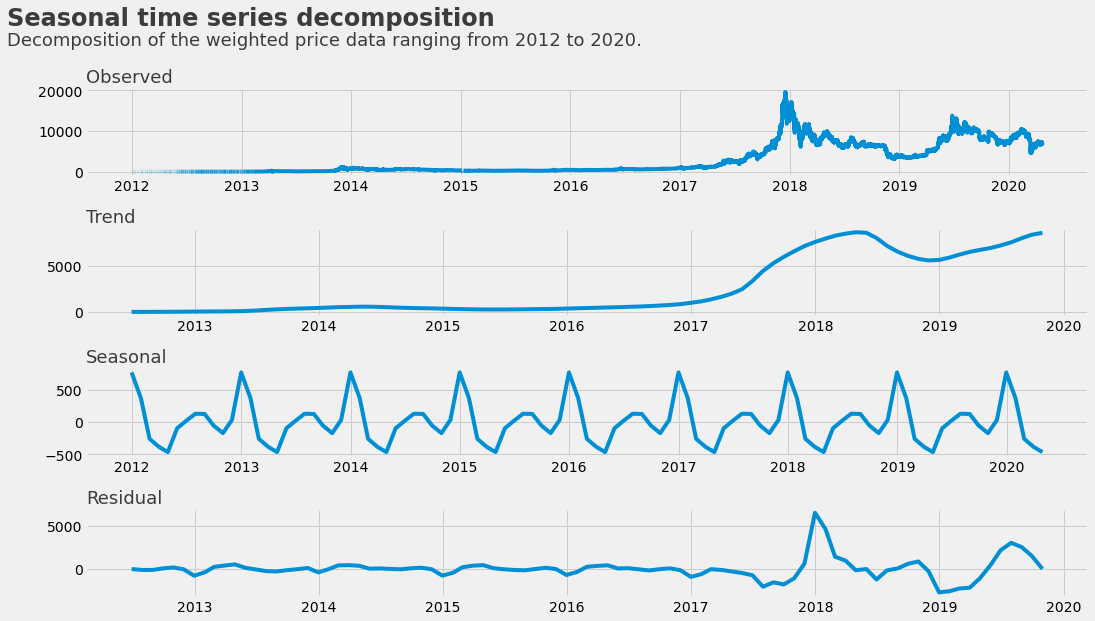

In [10]:
#Seasonal Decompose
ax, fig = plt.subplots(figsize=(15,8), sharex=True)

df_month = df.resample("M").mean()
dec = sm.tsa.seasonal_decompose(df_month["Weighted_Price"])


plt.subplot(411)
plt.plot(df_hour["Weighted_Price"], label="Weighted Price")
plt.title("Observed",loc="left", alpha=0.75, fontsize=18)

plt.subplot(412)
plt.plot(dec.trend, label="Trend")
plt.title("Trend",loc="left", alpha=0.75, fontsize=18)

plt.subplot(413)
plt.plot(dec.seasonal, label="Seasonal")
plt.title("Seasonal",loc="left", alpha=0.75, fontsize=18)

plt.subplot(414)
plt.plot(dec.resid, label="Residual")
plt.title("Residual",loc="left", alpha=0.75, fontsize=18)
plt.tight_layout()

plt.text(x=datetime.date(2011, 6, 30), y=63000, s="Seasonal time series decomposition",fontsize=24, weight="bold", alpha=0.75)
plt.text(x=datetime.date(2011, 6, 30), y=60700, s="Decomposition of the weighted price data ranging from 2012 to 2020.",fontsize=18, alpha=0.75)

gc.collect()

From the plot above we can see a few things:

* Bitcoin prices are facing a strong upward trend.
* There are some seasonal elements to the price (+- 500)
* Most of the noise in the data was generated during the "hype" phase of 2018-2019.

# **Stationarity**

**What is stationarity?** Stationarity in (plain English) means that the statistical properties of a ceratin variable do not change over time.

**Why you do it?** It simplifies the whole analytics process and allows for a structured approach to the problem.

**Do I need it for SARIMAX?** Not really. Statsmodels SARIMAX has a (by default enabled option) that enforces stationarity. However, it is a great tool to analyse the data and should be used.

Its common practice to use it and most models nowadays assume that the data is stationary. To determine the stationarity of data I am going to use the Dickey-Fuller test. The DF tests a null hypothesis that a unit root is present in an autoregressive model. If the value is less then <0.05 then the data is stationary.

In [11]:
print("Dicky-Fuller stationarity test - p: %f" % sm.tsa.adfuller(df_month["Weighted_Price"])[1])

Dicky-Fuller stationarity test - p: 0.419280


**Box-Cox**

Box-Cox comes from the family of power transformations and is often used as a mean to stabilize variance in a dataset. It is indexed by lambda and in certain times can be used as a differencing technique.

In [12]:
#Box-Cox

df_month["Box-Cox"], _ = stats.boxcox(df_month["Weighted_Price"])
print("Dicky-Fuller stationarity test - p: %f" % sm.tsa.adfuller(df_month["Box-Cox"])[1])

Dicky-Fuller stationarity test - p: 0.616565


**Panads diff()**

Pandas library provides an option for automatic differencing with diff().

In [13]:
#Automatic Differencing

first_diff = df_month["Weighted_Price"].diff()
print("Dicky-Fuller stationarity test - p: %f" % sm.tsa.adfuller(first_diff[1:])[1])
print("This series is stationary")


df_month["Auto_Diff"] = first_diff

Dicky-Fuller stationarity test - p: 0.000000
This series is stationary


Now lets plot the seasonal decomposition and AC & PAC on the stationary data so we can see the results.

10312

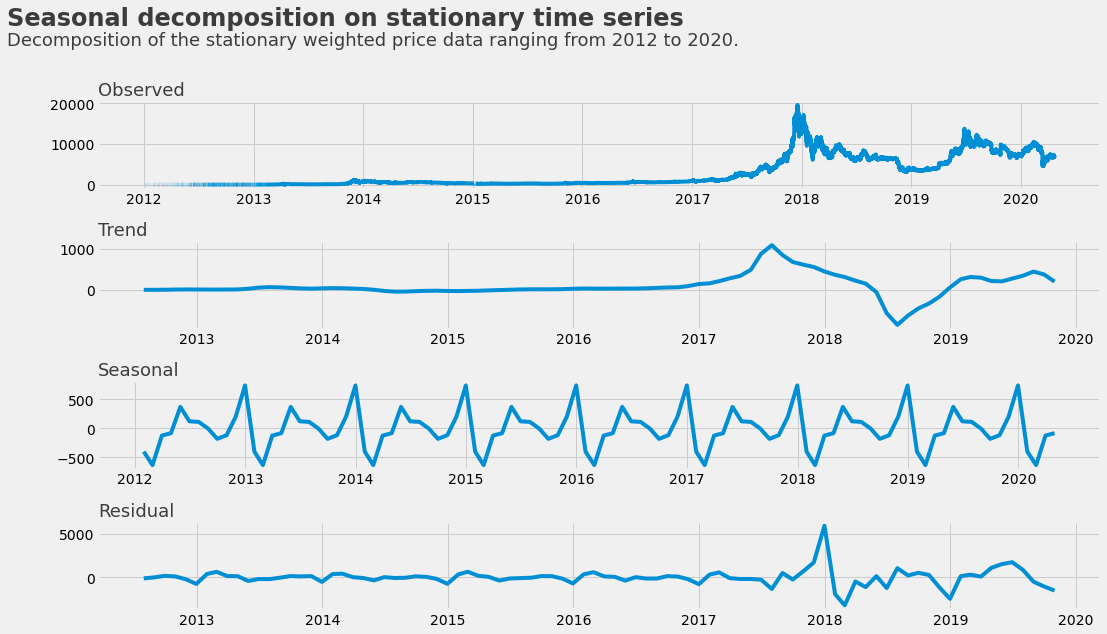

In [14]:
#Data
seasonal_dec = sm.tsa.seasonal_decompose(df_month["Auto_Diff"][1:])

#Seasonal Decompose on stationary series
ax, fig = plt.subplots(figsize=(15,8), sharex=True)

df_month = df.resample("M").mean()
dec = sm.tsa.seasonal_decompose(df_month["Weighted_Price"])


plt.subplot(411)
plt.plot(df_hour["Weighted_Price"], label="Weighted Price")
plt.title("Observed",loc="left", alpha=0.75, fontsize=18)

plt.subplot(412)
plt.plot(seasonal_dec.trend, label="Trend")
plt.title("Trend",loc="left", alpha=0.75, fontsize=18)

plt.subplot(413)
plt.plot(seasonal_dec.seasonal, label="Seasonal")
plt.title("Seasonal",loc="left", alpha=0.75, fontsize=18)

plt.subplot(414)
plt.plot(seasonal_dec.resid, label="Residual")
plt.title("Residual",loc="left", alpha=0.75, fontsize=18)
plt.tight_layout()

plt.text(x=datetime.date(2011, 6, 30), y=63000, s="Seasonal decomposition on stationary time series",fontsize=24, weight="bold", alpha=0.75)
plt.text(x=datetime.date(2011, 6, 30), y=60700, s="Decomposition of the stationary weighted price data ranging from 2012 to 2020.",fontsize=18, alpha=0.75)

gc.collect()

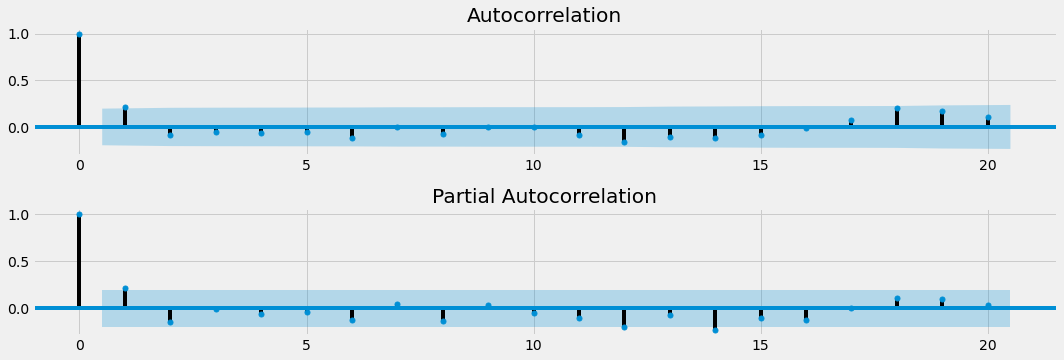

In [15]:
ax, fig = plt.subplots(figsize=(15,10))

plt.subplot(411)
x = sm.graphics.tsa.plot_acf(first_diff[1:], ax=plt.gca())
plt.subplot(412)
y = sm.graphics.tsa.plot_pacf(first_diff[1:],ax=plt.gca())
plt.tight_layout()

gc.collect()
del x,y

# **SARIMAX**

SARIMAX is short for the Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model. It is a widely used forecasting method for univariate time-series forecasting SARIMAX can handle both trends and seasonality in data. This makes it an excellent choice in forecasting data that has both of these elements.

In [16]:
###SARIMAX###

#Constructs all possible parameter combinations.
p = d = q = range(0,2)
pdq = list(itertools.product(p,d,q))

seasonal_pdq = [(x[0],x[1],x[2],12) for x in list(itertools.product(p,d,q))]

In [17]:
def sarimax_function(data,pdq,s_pdq):

    """
    The function uses a brute force approach to apply all possible pdq combinations and evaluate the model
    """

    result_list = []
    for param in pdq:
        for s_param in s_pdq:

            model = sm.tsa.statespace.SARIMAX(data, order=param, seasonal_order=s_param,
            enforce_invertibility=False,enforce_stationarity=False)

            results = model.fit()
            result_list.append([param,s_param,results.aic])
            print("ARIMA Parameters: {} x: {}. AIC: {}".format(param,s_param,results.aic))

    return result_list,results

The evaluation metric for the model selection was AIC (Akaike Information Criterion -> AIC=ln (sm2) + 2m/T). As a model selection tool, AIC has some limitations as it only provides a relative evaluation of the model. However, it is an excellent metric for checking the general quality of a model such as SARIMAX.

Lets start training.

In [18]:
result_list,results = sarimax_function(df_month["Weighted_Price"],pdq,seasonal_pdq)

gc.collect()

ARIMA Parameters: (0, 0, 0) x: (0, 0, 0, 12). AIC: 1971.3501560130628
ARIMA Parameters: (0, 0, 0) x: (0, 0, 1, 12). AIC: 1737.160643953264
ARIMA Parameters: (0, 0, 0) x: (0, 1, 0, 12). AIC: 1693.7635334946203
ARIMA Parameters: (0, 0, 0) x: (0, 1, 1, 12). AIC: 1467.519296218263
ARIMA Parameters: (0, 0, 0) x: (1, 0, 0, 12). AIC: 1713.0329948472806
ARIMA Parameters: (0, 0, 0) x: (1, 0, 1, 12). AIC: 1665.8388932588123
ARIMA Parameters: (0, 0, 0) x: (1, 1, 0, 12). AIC: 1482.330981933962
ARIMA Parameters: (0, 0, 0) x: (1, 1, 1, 12). AIC: 1468.5895032828125
ARIMA Parameters: (0, 0, 1) x: (0, 0, 0, 12). AIC: 1833.5107011211294
ARIMA Parameters: (0, 0, 1) x: (0, 0, 1, 12). AIC: 1607.532808474082
ARIMA Parameters: (0, 0, 1) x: (0, 1, 0, 12). AIC: 1589.8426815939529
ARIMA Parameters: (0, 0, 1) x: (0, 1, 1, 12). AIC: 1373.2935449046272
ARIMA Parameters: (0, 0, 1) x: (1, 0, 0, 12). AIC: 1622.2882911960364
ARIMA Parameters: (0, 0, 1) x: (1, 0, 1, 12). AIC: 1577.836371769035
ARIMA Parameters: (0, 0, 

28

In [19]:
#Dataframe of all results and parameters.

results_dataframe = pd.DataFrame(result_list, columns=["dpq","s_dpq","aic"]).sort_values(by="aic")
results_dataframe.head()

,dpq,s_dpq,aic
31,"(0, 1, 1)","(1, 1, 1, 12)",1273.860914
63,"(1, 1, 1)","(1, 1, 1, 12)",1273.922449
27,"(0, 1, 1)","(0, 1, 1, 12)",1274.394806
59,"(1, 1, 1)","(0, 1, 1, 12)",1274.892548
55,"(1, 1, 0)","(1, 1, 1, 12)",1290.790096


In [20]:
model = sm.tsa.statespace.SARIMAX(df_month["Weighted_Price"], order=(0, 1, 1), seasonal_order=(1, 1, 1, 12),
            enforce_invertibility=False,enforce_stationarity=False).fit()
print(model.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2396      0.056      4.281      0.000       0.130       0.349
ar.S.L12      -0.2165      0.150     -1.442      0.149      -0.511       0.078
ma.S.L12      -1.0058      0.071    -14.120      0.000      -1.145      -0.866
sigma2      1.302e+06   5.46e-08   2.39e+13      0.000     1.3e+06     1.3e+06


6252

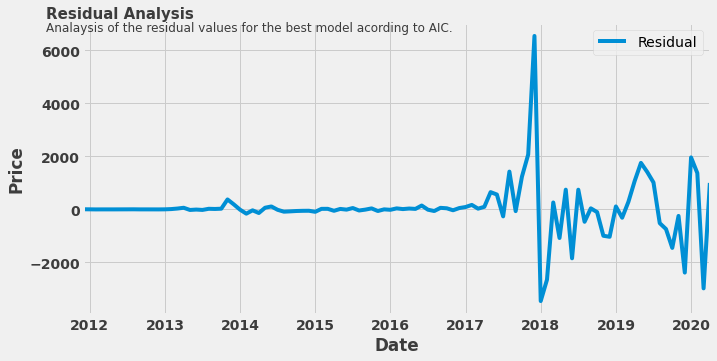

In [21]:
#Residual analysis
ax, fig = plt.subplots(figsize = (10,5))

model.resid.plot(label="Residual")

plt.xticks(alpha=0.75, weight="bold")
plt.yticks(alpha=0.75, weight="bold")

plt.xlabel("Date",alpha=0.75, weight="bold")
plt.ylabel("Price",alpha=0.75, weight="bold")

plt.legend()

plt.text(x=datetime.date(2011, 6, 30), y=7200, s="Residual Analysis",
fontsize=15, weight="bold", alpha=0.75)
plt.text(x=datetime.date(2011, 6, 30), y=6700, s="Analaysis of the residual values for the best model acording to AIC.",fontsize=12, alpha=0.75)

gc.collect()

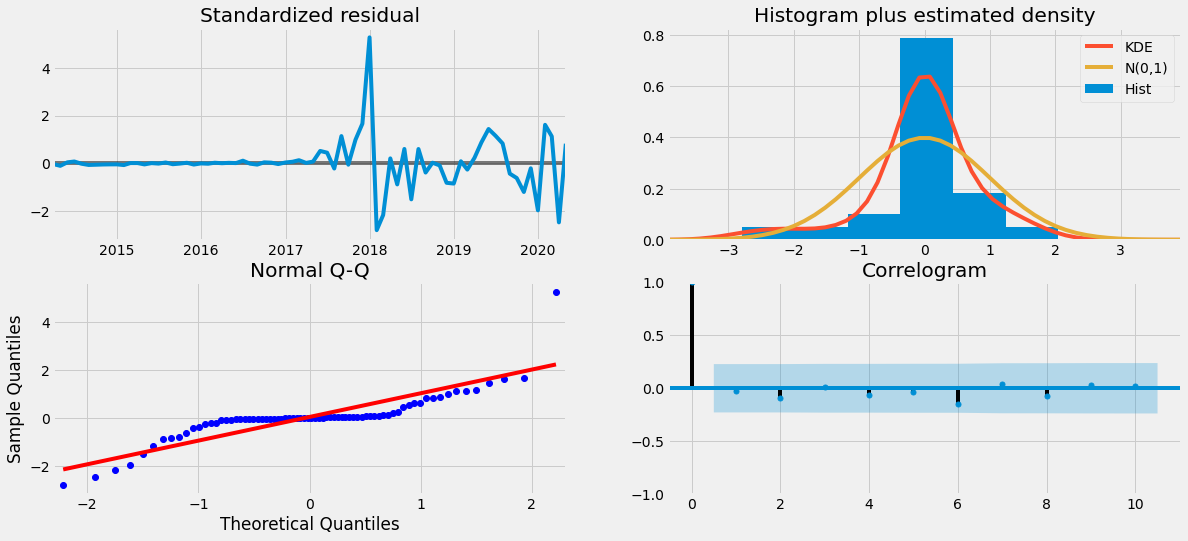

In [22]:
x = model.plot_diagnostics(figsize=(18, 8))

gc.collect()
del x

In [23]:
df_month_prediction = df_month[["Weighted_Price"]]

df_month_prediction["Forcasting"] = model.predict(start=pd.to_datetime("2011-12-31"), end=pd.to_datetime("2020-04-30"))

13918

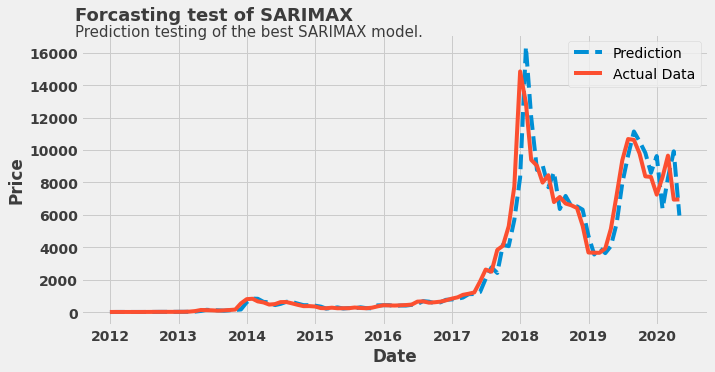

In [24]:
ax, fig = plt.subplots(figsize = (10,5))

plt.plot(df_month_prediction["Forcasting"], ls="--", label="Prediction")
plt.plot(df_month_prediction["Weighted_Price"], label="Actual Data")

plt.xticks(alpha=0.75, weight="bold")
plt.yticks(alpha=0.75, weight="bold")

plt.xlabel("Date",alpha=0.75, weight="bold")
plt.ylabel("Price",alpha=0.75, weight="bold")

plt.legend()

plt.text(x=datetime.date(2011, 6, 30), y=18000, s="Forcasting test of SARIMAX",
fontsize=18, weight="bold", alpha=0.75)
plt.text(x=datetime.date(2011, 6, 30), y=17000, s="Prediction testing of the best SARIMAX model.",fontsize=15, alpha=0.75)

gc.collect()

In [25]:
#Datetimeindex dates I want to predict

future_dates = [df_month_prediction.index[-1] + DateOffset(months = x)for x in range(1,12)]
future_dates = pd.to_datetime(future_dates)  +  MonthEnd(0)
future = pd.DataFrame(index=future_dates)
df_month_prediction = pd.concat([df_month_prediction,future])

gc.collect()

20

In [26]:
#Prediction

df_month_prediction["Future_forcast"] = model.predict(start=pd.to_datetime("2020-03-31"),end=pd.to_datetime("2021-03-31"))

pred = model.get_prediction(start=pd.to_datetime("2020-03-31"),end=pd.to_datetime("2021-03-31"))
pred_ci = pred.conf_int()

gc.collect()

41

3445

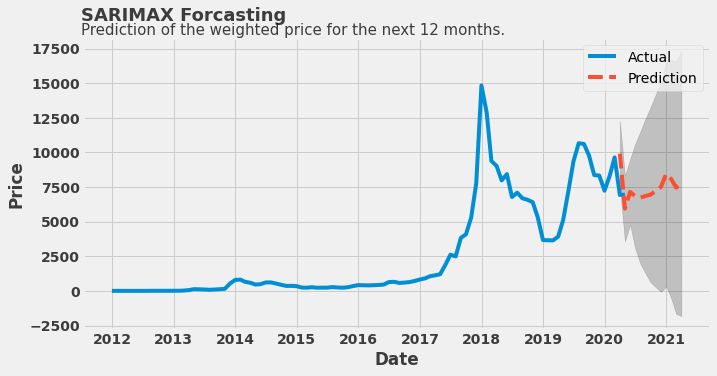

In [27]:
ax, fig = plt.subplots(figsize=(10,5))

plt.plot(df_month_prediction["Weighted_Price"], label="Actual")
plt.plot(df_month_prediction["Future_forcast"],ls="--", label="Prediction")

plt.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.legend()


plt.xticks(alpha=0.75, weight="bold")
plt.yticks(alpha=0.75, weight="bold")

plt.xlabel("Date",alpha=0.75, weight="bold")
plt.ylabel("Price",alpha=0.75, weight="bold")

plt.legend()

plt.text(x=datetime.date(2011, 6, 30), y=19500, s="SARIMAX Forcasting",
fontsize=18, weight="bold", alpha=0.75)
plt.text(x=datetime.date(2011, 6, 30), y=18500, s="Prediction of the weighted price for the next 12 months.",fontsize=15, alpha=0.75)

gc.collect()

# **Conclusion**

SARIMAX is a great and interesting method to predict univariate time-series data. It is a great way to refresh your knowledge on time-series data and strengthen the number of prediction models you know (because there is no free lunch in ML). I had fun making it and I hope you had fun reading it.

Thank you for your time.